# SOM_SpS Analysis

### This script is designed to explore the impact of prescribing SST while running the Los Alamos Sea Ice Model (CICE5) within the Community Earth System Model (CESM2), relative to using a slab ocean component.

#### Goals: 
1. Determine when each model run has reached equilibrium
2. Examine the reaction of the model to a longwave perturbation in both the prescribed SST(SpS) and slab ocean (SOM) cases
3. Investigate how a dynamic atmosphere might communicate the impact of prescribing SST over using a slab ocean

#### Setup: 

There will be 8 experimental cases centered around a slab ocean control run forced with daily initial conditions (dSOMcontrol). Four are dynamic ice + data atmosphere + SOM/SpS and four are dynamic ice + dynamic atmosphere + SOM/SpS. Within each group of four, the SOM/SpS pairs exist as either a control set or a longwave perturbed set.

The first part of this notebook will establish the equilibrium point that caps the spin up of each run. 

The second part will compare between SOM/SpS control and perturbed pairs for the data atmosphere cases.

The third part will do the same for the dynamic atmosphere cases.

The fourth will attempt to isolate the differences between the data and dynamic atmosphere scenarios. 

Files used live on NCAR's Cheyenne, in the glade directories of Cecilia Bitz (bitz), Vince Cooper (vcooper), and Molly Wieringa (mollyw)

#### In the words of vcooper, greetings! ...and beware.

### Preliminaries: set up the environment

In [5]:
%matplotlib inline

# math
import numpy as np
import numpy.ma as ma
import scipy as sc

# data
import xarray as xr
import pandas
import os
import os.path
import nc_time_axis
import glob
import csv

#plotting 
import matplotlib as mpl 
import matplotlib.path as mpath
from matplotlib import pyplot as plt 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import cmocean as cmo

mpl.rcParams['font.size'] = 16

#### Import Data

In [2]:
## NOTE: Edit this to read full timeseries generated on cheyenne, rather than individual history files! mmw,05/22 ##

mmw_path = '/glade/scratch/mollyw/archive/' #/SOMcontrol/ice/hist/'
cmb_path = '/glade/scratch/bitz/archive/' #/SOMcontrol/ice/hist/'
vtc_path = '/glade/scratch/vcooper/archive/'

paths= [mmw_path,
       cmb_path,
       vtc_path]

cases = ['SOMcontrol',
         'dSOMcontrol',
         'dSpScontrol',
         'dSOMperturb',
         'dSpSperturb'
        ]

runtime = {'SOMcontrol' : (1,41),
           'dSOMcontrol': (1,100),
           'dSpScontrol': (61,130),
           'dSOMperturb': (61,120),
           'dSpSperturb': (61,100)
          }

In [3]:
fp={} #empty dictionary for file paths
ice={} #empty dictionary for datasets

for path in paths:
    for case in cases:
        address = path + case + '/ice/hist/'
        if address == vtc_path + 'SOMcontrol' + '/ice/hist/':
            print("skipped vtc SOMcontrol")
        elif os.path.exists(address) == True:
            ice[case]= {}
            if runtime[case][0] <= 10:
                for x in range(1,10):
                    fp["file000{0}_03".format(x)]= address + case + '.cice.h.000{0}-03.nc'.format(x)
                    fp["file000{0}_09".format(x)]= address + case + '.cice.h.000{0}-09.nc'.format(x)
                
                    ice[case][case + "_000{0}_03".format(x)] = xr.open_dataset(fp["file000{0}_03".format(x)])
                    ice[case][case + "_000{0}_09".format(x)] = xr.open_dataset(fp["file000{0}_09".format(x)])
                    
                if runtime[case][1] < 100:
                    for x in range(10,runtime[case][1] + 1):
                        fp["file00{00}_03".format(x)]= address + case + '.cice.h.00{00}-03.nc'.format(x)
                        fp["file00{00}_09".format(x)]= address + case + '.cice.h.00{00}-09.nc'.format(x)
                
                        ice[case][case + "_00{00}_03".format(x)] = xr.open_dataset(fp["file00{00}_03".format(x)])
                        ice[case][case + "_00{00}_09".format(x)] = xr.open_dataset(fp["file00{00}_09".format(x)])
                else:
                    for x in range(10,100):
                        fp["file00{00}_03".format(x)]= address + case + '.cice.h.00{00}-03.nc'.format(x)
                        fp["file00{00}_09".format(x)]= address + case + '.cice.h.00{00}-09.nc'.format(x)
                
                        ice[case][case + "_00{00}_03".format(x)] = xr.open_dataset(fp["file00{00}_03".format(x)])
                        ice[case][case + "_00{00}_09".format(x)] = xr.open_dataset(fp["file00{00}_09".format(x)])
                
                    for x in range(100,runtime[case][1] + 1): 
                        fp["file0{000}_03".format(x)]= address + case + '.cice.h.0{000}-03.nc'.format(x)
                        fp["file0{000}_09".format(x)]= address + case + '.cice.h.0{000}-09.nc'.format(x)
            
                        ice[case][case + "_0{000}_03".format(x)] = xr.open_dataset(fp["file0{000}_03".format(x)])
                        ice[case][case + "_0{000}_09".format(x)] = xr.open_dataset(fp["file0{000}_09".format(x)])
                    
            elif runtime[case][0] > 10 and runtime[case][0] < 100:
                for x in range(runtime[case][0],100):
                    fp["file00{00}_03".format(x)]= address + case + '.cice.h.00{00}-03.nc'.format(x)
                    fp["file00{00}_09".format(x)]= address + case + '.cice.h.00{00}-09.nc'.format(x)
                
                    ice[case][case + "_00{00}_03".format(x)] = xr.open_dataset(fp["file00{00}_03".format(x)])
                    ice[case][case + "_00{00}_09".format(x)] = xr.open_dataset(fp["file00{00}_09".format(x)])
                
                for x in range(100,runtime[case][1]+1): 
                    fp["file0{000}_03".format(x)]= address + case + '.cice.h.0{000}-03.nc'.format(x)
                    fp["file0{000}_09".format(x)]= address + case + '.cice.h.0{000}-09.nc'.format(x)
                
                    ice[case][case + "_0{000}_03".format(x)] = xr.open_dataset(fp["file0{000}_03".format(x)])
                    ice[case][case + "_0{000}_09".format(x)] = xr.open_dataset(fp["file0{000}_09".format(x)])
            
            else:
                for x in range(100, runtime[case][1] + 1):
                    fp["file0{000}_03".format(x)]= address + case + '.cice.h.0{000}-03.nc'.format(x)
                    fp["file0{000}_09".format(x)]= address + case + '.cice.h.0{000}-09.nc'.format(x)
                
                    ice[case][case + "_0{000}_03".format(x)] = xr.open_dataset(fp["file0{000}_03".format(x)])
                    ice[case][case + "_0{000}_09".format(x)] = xr.open_dataset(fp["file0{000}_09".format(x)])
                    
        else: 
            print(path + case + ' does not exist')
        
        

/glade/u/home/mollyw/mmwpylib/lib/python2.7/site-packages/xarray/coding/times.py:111: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/glade/u/home/mollyw/mmwpylib/lib/python2.7/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])


/glade/scratch/mollyw/archive/dSpScontrol does not exist
/glade/scratch/mollyw/archive/dSpSperturb does not exist
/glade/scratch/bitz/archive/dSOMcontrol does not exist
/glade/scratch/bitz/archive/dSpScontrol does not exist
/glade/scratch/bitz/archive/dSOMperturb does not exist
/glade/scratch/bitz/archive/dSpSperturb does not exist
skipped vtc SOMcontrol
/glade/scratch/vcooper/archive/dSOMcontrol does not exist
/glade/scratch/vcooper/archive/dSOMperturb does not exist


### Part 1: Equilibrium 

This is currently running only for dSOM in this notebook; needs work to streamline, automate, and apply to other runs

#### Load volume data

In [ ]:
volumes = {}
mmw_workpath = '/glade/work/mollyw/SOM_SPS/'

experiments = ['control',  #would like to extend to be of the format dSOMcontrol, dSpScontrol etc.
               'perturb'
              ]

hemispheres = ['nh',
               'sh'
              ]

for experiment in experiments:
    volumes[experiment] = {}
    for hemisphere in hemispheres:
        volumes[experiment][hemisphere] = np.loadtxt(mmw_workpath + 'volumes/' + experiment + '/icevol_d' + hemisphere + '_dSOM' + experiment + '.txt')


In [ ]:
NHlist = []
SHlist = []

## USE THIS TO SMOOTH
#annualmean = icevol_nh_dSOMcontrol.reshape(12,icevol_nh_dSOMcontrol.size//12,order='F').mean(axis=0)
#annualmax = icevol_nh_dSOMcontrol.reshape(12,icevol_nh_dSOMcontrol.size//12,order='F').max(axis=0)
## 


for experiment in experiments:
    for hemisphere in hemispheres:
        
        annualmean = volumes[experiment][hemisphere].reshape(12,volumes[experiment][hemisphere].size//12,order='F').mean(axis=0)
        annualmax = volumes[experiment][hemisphere].reshape(12,volumes[experiment][hemisphere].size//12,order='F').max(axis=0)
        
        eq = (annualmean[1:]/annualmean[0:-1]-1)*100
        percent = (annualmean[1:]-annualmean[0:-1])/annualmax[1:]*100
        
        # There is probably a better way to do this smoothing with a python package; come back to this later
        '''Hlist = []
        for i in range(6,(len(volumes[experiment][hemisphere])-5)):
            Hlist.append(sum(volumes[experiment][hemisphere][(i-6):(i+6)]/12))
            
        H = np.asarray(Hlist)

        # Calculate the equilibrium point
        timefor = np.arange(0, len(H))
        timeback = np.flip(timefor,0)

        seasonal = volumes[experiment][hemisphere]
        
        eq = []
        percent = []

        for x in timeback:
            eq.append((H[x] - H[x-12])/H[x]*100)
            seas_max = (seasonal[0+11*x/12:11+11*x/12].max())
            percent.append(((H[x] - H[x-12])/(seas_max))*100)'''
            
            
        volumes[experiment][hemisphere + '_eq'] = eq
        volumes[experiment][hemisphere + '_percent'] = percent
            

In [ ]:
for experiment in experiments: 
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,6))

    axes[0].plot(volumes[experiment]['nh_eq'], label = "% change (n-1)")
    axes[0].plot(volumes[experiment]['nh_percent'], label = "% of seasonal maximum")
    axes[0].axhline(0.01, ls = '--', c = 'g', lw = 0.75, label='+ 0.01%')
    axes[0].axhline(0, ls = '-', c = 'k', lw = 1.00)
    axes[0].axhline(-0.01, ls = '--', c = 'g', lw = 0.75, label='- 0.01%')
    axes[0].legend(loc = 'lower right')
    axes[0].set_title("Northern Hemisphere, % < 0.01")
    axes[0].set_ylim([-0.1, 0.1])
    #axes[0].set_xlim([12,len(np.flip(volumes[experiment]['nh_eq'],0))])
    axes[0].set_ylabel('percent change')
    axes[0].set_xlabel('time (months)')

    axes[1].plot(volumes[experiment]['sh_eq'], label = "% change (n-1)")
    axes[1].plot(volumes[experiment]['sh_percent'], label = "% of seasonal maximum")
    axes[1].axhline(0.01, ls = '--', c = 'g', lw = 0.75, label='+ 0.01%')
    axes[1].axhline(0, ls = '-', c = 'k', lw = 1.00)
    axes[1].axhline(-0.01, ls = '--', c = 'g', lw = 0.75, label='- 0.01%')
    axes[1].legend(loc = 'lower right')
    axes[1].set_title("Southern Hemisphere, % < 0.01")
    axes[1].set_ylim([-0.1, 0.1])
    #axes[1].set_xlim([12,len(np.flip(volumes[experiment]['nh_eq'],0))])
    axes[1].set_ylabel('percent change')
    axes[1].set_xlabel('time (months)')

    plt.suptitle('Equilibrium in ' + str.capitalize(experiment))

In [ ]:
ice

### Part 2: dSOM and dSpS

The Polar Stereo code is plotting empty values for me (mmw), even with vtc's grid hack. I have double checked and matched packages, tested different dSOMcontrol and dSpScontrol files from both mmw and vtc, and note that the colorbar scales are appropriate for values we would expect for both the normal concentration and the difference plots. I am not quite sure what to do from here, but will keep investigating. Perhaps this is something to do with my ncar_pylib configuration...

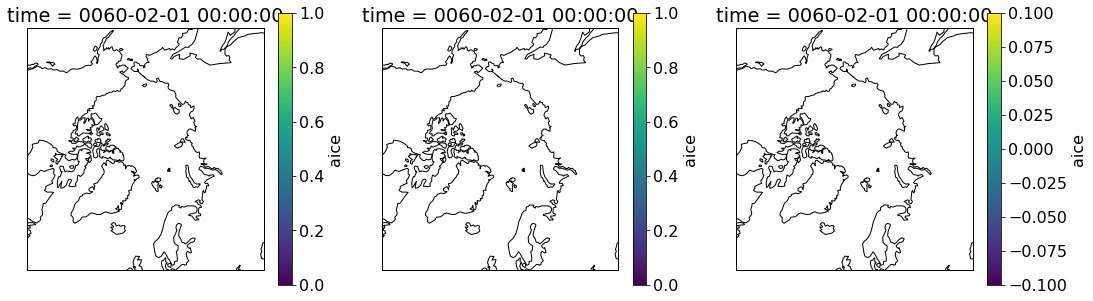

<Figure size 432x288 with 0 Axes>

In [11]:
### PLOTTING SCRIPT for STEREO PLOTS ###
########## TO BE FORMATTED #############
case = 'dSOMcontrol'
time = '0060_03'

grid = xr.open_dataset('/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')
path = '/glade/scratch/vcooper/archive/mollyw_slab/'

dSOMcontrol = xr.open_dataset(path + 'dSOMcontrol.cice.h.0060.nc')
dSOMcontrol = ice[case][case + '_' + time] # quick note to self here that we can streamline the loading, removing double reference to "case"
dSOMcontrol.TLAT[:] = grid.lat # hack to fix polar stereo
dSOMcontrol.TLON[:] = grid.lon

# aice NH
fig = plt.figure(figsize=(18,5))

# SOM control
ax1 = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
ax1.coastlines()
ax1.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
dSOMcontrol.aice[0,:,:].plot.pcolormesh('TLON', 'TLAT', ax=ax1, transform=ccrs.PlateCarree())

# SpS control
ax2 = plt.subplot(1,3,2,projection=ccrs.NorthPolarStereo())
plt.title('test')
ax2.coastlines()
ax2.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
dSOMcontrol.aice[0,:,:].plot.pcolormesh('TLON', 'TLAT', ax=ax2, transform=ccrs.PlateCarree())

# diff
ax3 = plt.subplot(1,3,3,projection=ccrs.NorthPolarStereo())
ax3.coastlines()
ax3.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
diff = dSOMcontrol.aice[0,:,:] - dSOMcontrol.aice[0,:,:]
diff.plot.pcolormesh('TLON', 'TLAT', ax=ax3, transform=ccrs.PlateCarree())

plt.show()
plt.tight_layout()

### Part 3: atmSOM and atm SpS

### Part 4: AGCM vs DATM